# generate the tracks and blob energies from the truth information MC

In [2]:

# import stuff
import sys,os,os.path
import csv
import traceback
#sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/scratch/halmazan/NEXT/IC_alter-blob-centre/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/scratch/halmazan/NEXT/testing/notebooks/FOM_creator/")
os.environ['ICTDIR']='/scratch/halmazan/NEXT/IC_alter-blob-centre/'

from invisible_cities.core.core_functions   import shift_to_bin_centers
from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer

import FOM_functions as FOM_func
import functions_HE as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd





import scipy.special as special
from scipy.stats import norm
from scipy.stats import skewnorm, crystalball
from scipy.optimize import curve_fit
from tqdm import tqdm

from scipy.integrate import quad

import iminuit
from iminuit import Minuit
import probfit
from concurrent.futures import ProcessPoolExecutor

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

from typing          import Optional
from typing          import Union
from typing          import Callable

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
from pathlib import Path

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
#from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm

In [3]:


def load_single_file(file_path):
    '''
    Load data from a single h5 file and produce dataframes for /Tracking/Tracks

    Args:
        file_path       :       str
                                Path to the h5 file to be loaded.

    Returns:
        tracks_df       :       pandas.DataFrame
                                DataFrame containing the /Tracking/Tracks data.
    '''
    try: 
        tracks_df = load_dst(file_path, 'MC', 'hits')
        return tracks_df
    except Exception as e:
        print(f'File {file_path} broke with error:\n{e}', flush = True)
        x = pd.DataFrame()
        return x

## FUNCTIONS ##

def load_data_fast(folder_path):
    '''
    Load multiple h5 files and produce concatenated dataframes for /Tracking/Tracks, /MC/Particles, and their corresponding eventmap.

    Args:
        folder_path     :       str
                                Path to the folder containing the h5 files.

    Returns:
        tracks          :       pandas.DataFrame
                                Concatenated DataFrame containing the /Tracking/Tracks data from all h5 files.
        
        particles       :       pandas.DataFrame
                                Concatenated DataFrame containing the /MC/particles data from all h5 files, with the 'event_id' column modified.

        eventmap        :       pandas.DataFrame
                                Concatenated DataFrame containing the event map from all h5 files.
    '''
    
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    file_paths = [os.path.join(folder_path, f) for f in file_names]

    # Use ProcessPoolExecutor to parallelize the data loading process
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(load_single_file, file_paths))
    
    # Separate the results into respective lists
    tracks_list = results

    # Concatenate all the dataframes at once
    tracks = pd.concat(tracks_list, axis=0, ignore_index=True)

    return tracks


def load_data(pth):
    hdst = []

    for i in tqdm(range(1,8)):
        print(f"LDC {i}", flush = True)
        flder_pth = pth + 'ldc' + str(i) + '/'
        hdst.append(load_data_fast(flder_pth))

    hdst = pd.concat(hdst)
    return hdst


def load_data_small(pth):
    hdst = []

    i = 1
    print(f"LDC {i}", flush = True)
    flder_pth = pth + 'ldc' + str(i) + '/'
    hdst.append(load_data_fast(flder_pth[:10]))

    hdst = pd.concat(hdst)
    return hdst



In [4]:

# MC
RUN_NUMBER = '250925'
TIMESTAMP = ['456018']

# data
#RUN_NUMBER = '15589, 15590, 15591, 15592'
#TIMESTAMP = ['456018'] * 4
#TIMESTAMP = ['354015'] * 4

RUN_NUMBER = [int(x) for x in RUN_NUMBER.split(',')]
CITY       = 'thekla'


# load
hdst_local = []
for RN, TS in zip(RUN_NUMBER, TIMESTAMP):
    print(f'R{RN}: {TS}', flush = True)
    #n100_dir = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data/{RN}/{TS}/'
    #n100_dir = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data/{RN}/isaura/{TS}/'
    n100_dir = f'/scratch/halmazan/NEXT/PROCESSING/topology_cuts/data_MC/{RN}/{TS}/'
    hdst_local.append(pd.read_hdf(f'{n100_dir}cut_hdst.h5'))
    print(f'Loaded!', flush = True)
hdst = pd.concat(hdst_local)


MChits = []
for RN, TS in zip(RUN_NUMBER, TIMESTAMP):
    n100_dir_truth = f'/data/halmazan/NEXT/N100_LPR_MC/{RN}/{CITY}/{TS}/ldc1/'
    truth_files = [os.path.join(n100_dir_truth, f) for f in os.listdir(n100_dir_truth) if f.endswith('.h5')]
    hits_dst = load_dst(truth_files[0], 'MC', 'hits')


R250925: 456018
Loaded!


In [5]:
display(hdst)
display(hits_dst)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
24,226716014,0,1.561308,348.308525,250,767,1,-3.575,-309.875,117.997121,...,127.048900,149.925,-155.375,296.930897,0.606233,0.198138,0.0,16.781818,16.679167,17.030071
35,226716022,0,1.667355,383.833994,347,1052,1,-126.975,-63.075,585.078154,...,764.482819,-34.675,183.725,610.822702,0.427723,0.163080,0.0,16.905000,17.081579,17.045575
62,226716043,0,1.594626,233.907795,279,1062,1,-158.075,-233.125,1053.811207,...,1114.175925,-34.675,-63.075,1098.298419,0.485382,0.260486,0.0,17.975000,17.865385,16.642752
81,226716052,0,1.480074,178.457349,190,644,1,212.125,-48.025,384.225441,...,410.863624,273.325,60.825,499.061495,0.993079,0.220753,0.0,17.368750,17.166667,17.759318
87,226716055,0,1.469495,251.446643,280,920,1,88.725,-94.175,512.023003,...,535.927934,134.375,-16.425,584.906413,0.418808,0.310144,0.0,17.975000,16.872727,16.012819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329193,131328046,0,1.609148,309.568205,313,985,1,-96.875,168.175,869.428301,...,897.755420,134.375,276.025,897.042789,0.588601,0.344013,0.0,17.261765,17.005000,17.233232
329220,131328065,0,1.616456,199.174941,229,790,1,119.825,214.825,500.653626,...,526.704739,227.675,276.025,593.604386,0.662582,0.577195,0.0,16.905000,17.005000,17.256323
329230,131328071,0,1.634003,264.588815,261,821,1,227.675,-78.125,451.982128,...,495.080391,319.975,45.275,594.649494,0.766157,0.203872,0.0,17.368750,16.905000,16.913350
329239,131328077,0,1.516815,381.578063,309,928,1,42.075,75.875,695.287633,...,858.217108,257.775,214.325,720.668518,0.551889,0.199457,0.0,17.261765,16.827273,17.349856


,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,226716000,41,0,159.825882,310.863373,461.121735,0.920929,0.000048,ACTIVE
1,226716000,45,0,159.826111,310.863281,461.121704,0.920992,0.000044,ACTIVE
2,226716000,44,0,159.825943,310.863159,461.121887,0.921000,0.000045,ACTIVE
3,226716000,43,0,159.825195,310.863251,461.122467,0.921002,0.000553,ACTIVE
4,226716000,42,0,158.936218,310.508759,460.834229,0.924321,0.000447,ACTIVE
...,...,...,...,...,...,...,...,...,...
99091,226716087,41,451,239.237305,403.086517,568.762634,1.814028,0.000014,ACTIVE
99092,226716087,41,452,239.237442,403.085754,568.764099,1.814090,0.000362,ACTIVE
99093,226716087,41,453,239.237930,403.085785,568.765198,1.814140,0.000031,ACTIVE
99094,226716087,41,454,239.238144,403.086700,568.766052,1.814193,0.000289,ACTIVE


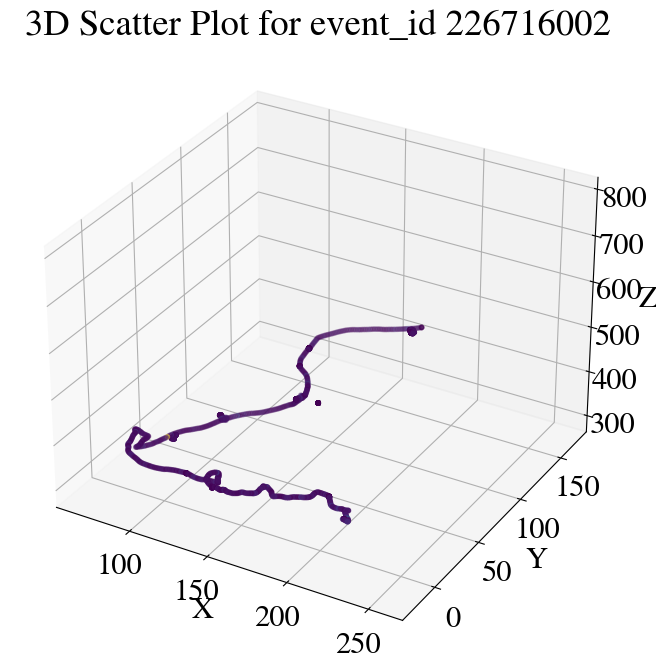

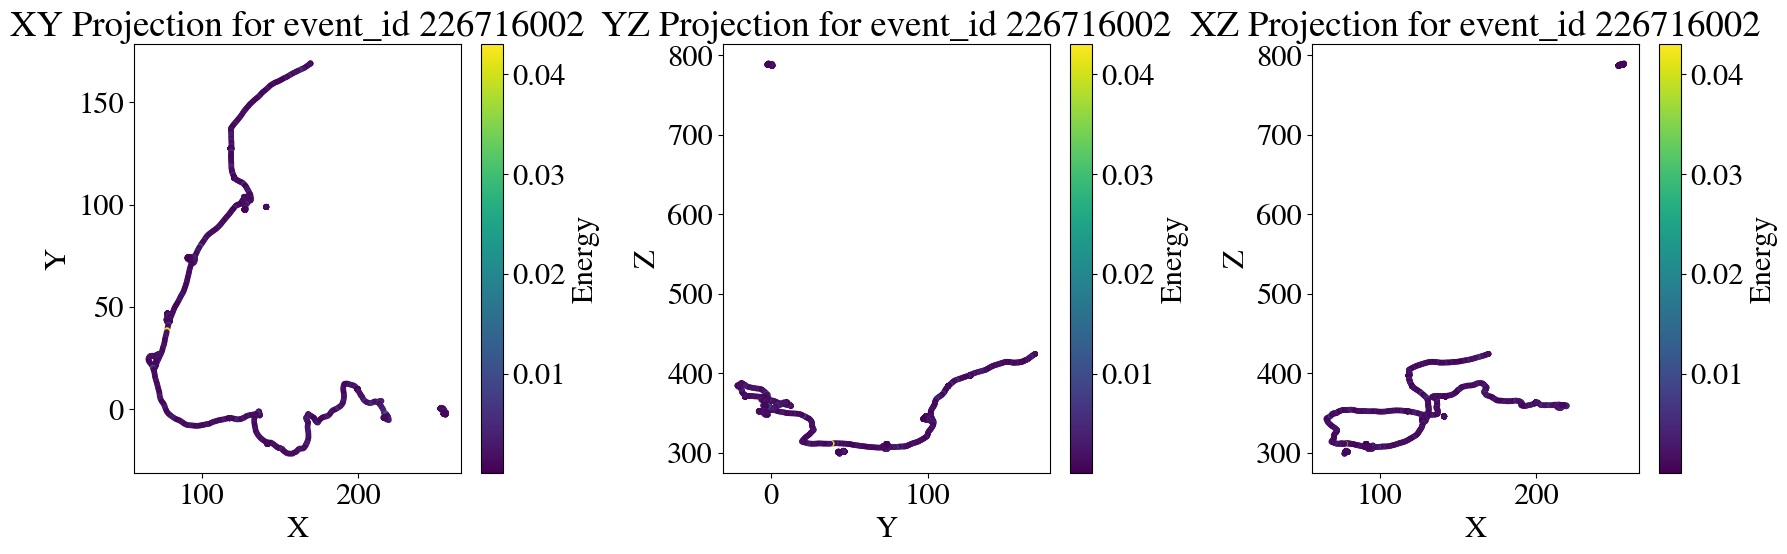

In [12]:
# Filter the hits_dst DataFrame for the specific event_id
specific_event_id = hits_dst.event_id.unique()[2]  # Replace with the desired event_id
event_hits = hits_dst[hits_dst['event_id'] == specific_event_id]

# Create a 3D scatter plot of the x, y, z coordinates
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(event_hits['x'], event_hits['y'], event_hits['z'], c=event_hits['energy'], cmap='viridis', s=10)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'3D Scatter Plot for event_id {specific_event_id}')

plt.show()

# Create subplots for xy, yz, and xz projections
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# XY projection
axs[0].scatter(event_hits['x'], event_hits['y'], c=event_hits['energy'], cmap='viridis', s=10)
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_title(f'XY Projection for event_id {specific_event_id}')
axs[0].colorbar = plt.colorbar(axs[0].collections[0], ax=axs[0], label='Energy')

# YZ projection
axs[1].scatter(event_hits['y'], event_hits['z'], c=event_hits['energy'], cmap='viridis', s=10)
axs[1].set_xlabel('Y')
axs[1].set_ylabel('Z')
axs[1].set_title(f'YZ Projection for event_id {specific_event_id}')
axs[1].colorbar = plt.colorbar(axs[1].collections[0], ax=axs[1], label='Energy')

# XZ projection
axs[2].scatter(event_hits['x'], event_hits['z'], c=event_hits['energy'], cmap='viridis', s=10)
axs[2].set_xlabel('X')
axs[2].set_ylabel('Z')
axs[2].set_title(f'XZ Projection for event_id {specific_event_id}')
axs[2].colorbar = plt.colorbar(axs[2].collections[0], ax=axs[2], label='Energy')

plt.tight_layout()
plt.show()

# extract the topology stuff

you have a couple of notebooks that do this.